In [16]:
# =============================================================================
# Main script to run a full end-to-end example for the abcnre package.
# =============================================================================

%load_ext autoreload
%autoreload 2

import jax
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# --- Imports from abcnre package ---
from abcnre.simulation import ABCSimulator
from abcnre.simulation.models import GaussGaussModel
from abcnre.inference.persistence import load_classifier, load_simulator_from_classifier_config
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unormalized_corrected_nre_pdf
from abcnre.diagnostics.viz import plot_posterior_comparison

[autoreload of abcnre.simulation.models failed: Traceback (most recent call last):
  File "/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/Users/antoineluciano/.pyenv/versions/3.10.13/lib/python3.10/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 883, in exec_module
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "/Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/src/abcnre/simulation/models/__init__.py", line 34, in <module>
    from .registry import (
ImportError: cannot import name 'get_example_

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
output_dir = Path("../results")
# simulator_path = output_dir / "gauss_1D_simulator.yml"
#network_config_path = output_dir / "config_mlp_reduce_on_plateau.yml"
final_config_path = output_dir / "gauss_1D_classifier_eps_inf_8066ecdd5fac.yml"



--- Step 6: Diagnostics and Visualization ---
✅ Using saved total feature dimension: 12
Initialized network with 37,297 parameters
✅ Classifier loaded from ../results/gauss_1D_classifier_eps_inf_8066ecdd5fac.yml
✅ Estimator loaded. Final validation accuracy: 0.946
✅ Simulator loaded from: ../results/gauss_1D_simulator_eps_inf_b7d408f5b633.yml
✅ Simulator loaded from classifier config: ../results/gauss_1D_simulator_eps_inf_b7d408f5b633.yml
✅ Simulator loaded from classifier config: ABCSimulator(model=GaussGaussModel, epsilon=inf, observed_data_shape=(10,))
Using full feature format: [data(10) + phi(1) + summary(1)] = 12 dims


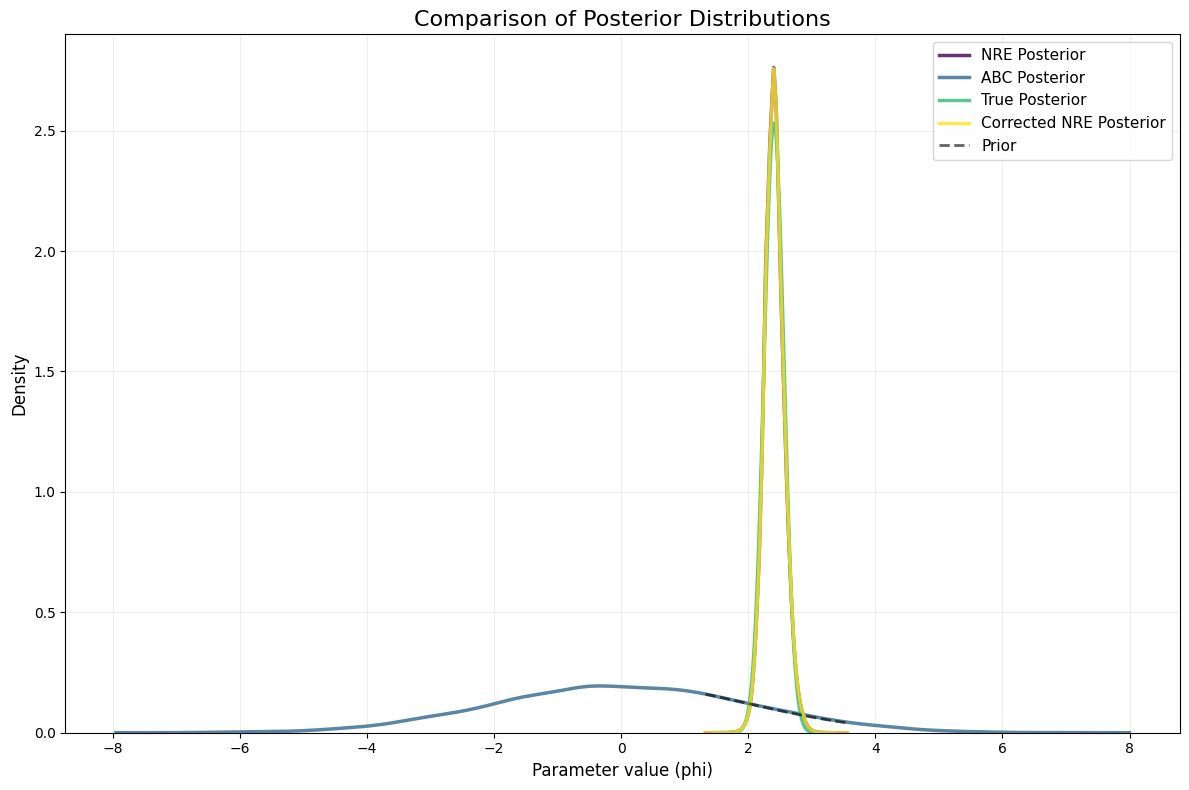


✅ Diagnostics complete.


In [12]:
# --- Step 6: Diagnostics and Visualization ---
print("\n--- Step 6: Diagnostics and Visualization ---")

# Load the classifier
loaded_estimator, abc_phi_samples, metrics = load_classifier(final_config_path)
print(f"✅ Estimator loaded. Final validation accuracy: {metrics.get('final_val_accuracy', -1):.3f}")

# Load the simulator using the new method (from classifier config)
loaded_simulator = load_simulator_from_classifier_config(final_config_path)
print(f"✅ Simulator loaded from classifier config: {loaded_simulator}")

min_phi, max_phi = np.min(abc_phi_samples), np.max(abc_phi_samples)

# Get posterior distributions
unnormalized_pdf_func = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
phi_grid, nre_pdf = get_normalized_pdf(unnormalized_pdf_func, initial_bounds=(min_phi, max_phi))

# Get prior for plotting
prior_pdf_values = loaded_simulator.model.prior_pdf(phi_grid)

true_grid, true_pdf = get_normalized_pdf(loaded_simulator.model.get_posterior_distribution(loaded_simulator.observed_data).pdf, initial_bounds=(min_phi, max_phi))

unnormalized_corrected_pdf_func = get_unormalized_corrected_nre_pdf(loaded_estimator, loaded_simulator, phi_samples=abc_phi_samples)

phi_corrected_grid, unnormalized_corrected_pdf = get_normalized_pdf(
    unnormalized_pdf_func=unnormalized_corrected_pdf_func,
    initial_bounds=(min_phi, max_phi),
    n_grid_points=10000
)

# Generate the comparison plot - flatten ABC samples to 1D
plot_posterior_comparison(
    distributions={
        'NRE Posterior': (phi_grid, nre_pdf), 
        'ABC Posterior': abc_phi_samples.flatten(),  # Flatten to 1D array
        'True Posterior': (true_grid, true_pdf), 
        'Corrected NRE Posterior': (phi_corrected_grid, unnormalized_corrected_pdf)
    },
    prior_pdf=(phi_grid, prior_pdf_values),
    save_path=output_dir / "posterior_comparison.png"
)

print("\n✅ Diagnostics complete.")

In [13]:
# --- Demonstration: Inspect Paths in Classifier Config ---
print("\n--- Paths stored in classifier configuration ---")

import yaml
with open(final_config_path, 'r') as f:
    classifier_config = yaml.safe_load(f)

print("Paths section in classifier config:")
paths = classifier_config.get('paths', {})
for key, path in paths.items():
    print(f"  {key}: {path}")

print(f"\nDemonstration: Loading simulator from path stored in classifier config")
print(f"Simulator config path: {paths.get('simulator_config_path', 'Not found')}")

# Show alternative method: Direct loading from stored path
if 'simulator_config_path' in paths:
    simulator_path_from_config = Path(paths['simulator_config_path'])
    if not simulator_path_from_config.is_absolute():
        simulator_path_from_config = final_config_path.parent / simulator_path_from_config
    
    # Alternative: Load directly using the stored path
    simulator_direct = ABCSimulator.load(simulator_path_from_config)
    print(f"✅ Alternative method: Direct loading from stored path works too")
    print(f"   Simulator epsilon: {simulator_direct.epsilon:.6f}")
else:
    print("❌ No simulator path found in classifier config")


--- Paths stored in classifier configuration ---
Paths section in classifier config:
  classifier_config_path: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/gauss_1D_classifier_eps_inf_8066ecdd5fac.yml
  weights_path: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/gauss_1D_weights_eps_inf_8066ecdd5fac.npy
  phis_path: /Users/antoineluciano/Documents/Recherche/ABC-SBI-1/abcnre/examples/gauss_1D/results/gauss_1D_phis_eps_inf_8066ecdd5fac.npy
  simulator_config_path: gauss_1D_simulator_eps_inf_b7d408f5b633.yml

Demonstration: Loading simulator from path stored in classifier config
Simulator config path: gauss_1D_simulator_eps_inf_b7d408f5b633.yml
✅ Simulator loaded from: ../results/gauss_1D_simulator_eps_inf_b7d408f5b633.yml
✅ Alternative method: Direct loading from stored path works too
   Simulator epsilon: inf



--- Step 7: Simulation-Based Calibration (SBC) ---
Running ABC-SBC by drawing 100 phi values from the ABC posterior...


ABC-SBC Progress: 100%|██████████| 100/100 [00:43<00:00,  2.31it/s]



ABC-SBC complete.


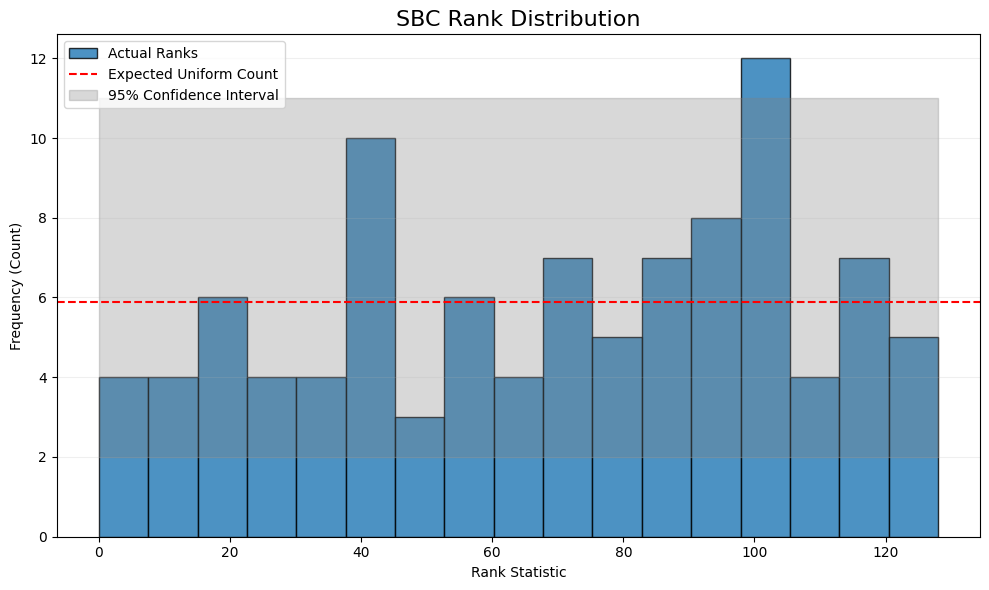

In [14]:
from abcnre.diagnostics.calibration import run_abc_sbc
from abcnre.diagnostics.viz import plot_sbc_ranks

# --- Step 7: Simulation-Based Calibration (SBC) ---
print("\n--- Step 7: Simulation-Based Calibration (SBC) ---")
import jax
key  = jax.random.PRNGKey(42)
num_posterior_samples = 128  
sbc_results = run_abc_sbc(
    key=key,
    estimator=loaded_estimator,
    simulator=loaded_simulator,
    abc_phi_samples=abc_phi_samples,
    num_sbc_rounds=100,
    num_posterior_samples=num_posterior_samples
)


plot_sbc_ranks(sbc_results["ranks"], save_path=output_dir / "sbc_ranks.png", num_posterior_samples=num_posterior_samples)

In [15]:
from abcnre.diagnostics.posterior import get_unnormalized_nre_pdf, get_normalized_pdf, get_unormalized_corrected_nre_pdf, get_sampler_from_pdf
from abcnre.diagnostics.metrics import generate_and_evaluate_metrics, save_metrics_to_csv
import json
%load_ext autoreload
%autoreload 2
# In your main script (e.g., run_diagnostics.py), after loading artifacts

print("\n--- Step 8: Creating Samplers and Running Metrics ---")

# Define bounds for posterior calculation based on reference samples
min_phi = np.min(abc_phi_samples) - 1.0
max_phi = np.max(abc_phi_samples) + 1.0

# --- Create all necessary sampler functions ---
# A sampler is a function that takes (n_samples, key) and returns samples

unorm_nre_pdf = get_unnormalized_nre_pdf(loaded_estimator, loaded_simulator)
nre_sampler = get_sampler_from_pdf(
    unnormalized_pdf_func=unorm_nre_pdf,
    initial_bounds=(min_phi, max_phi)
)

unorm_corrected_nre_pdf = get_unormalized_corrected_nre_pdf(
    loaded_estimator, loaded_simulator, phi_samples=abc_phi_samples
)
corrected_nre_sampler = get_sampler_from_pdf(
    unnormalized_pdf_func=unorm_corrected_nre_pdf,
    initial_bounds=(min_phi, max_phi)
)

true_sampler = loaded_simulator.get_true_posterior_samples

# abc_sampler = lambda: key, n_s:  loaded_simulator.get_abc_posterior_samples()

# --- Run the metrics suite ---
approx_samplers_dict = {
    "NRE_Standard": nre_sampler,
    "NRE_Corrected": corrected_nre_sampler,
    # "ABC": 
}

# The key here will be split inside the function for each sampler
key = jax.random.PRNGKey(123)
all_metrics_results = generate_and_evaluate_metrics(
    key=key,
    true_sampler=true_sampler,
    approx_samplers_dict=approx_samplers_dict,
    n_samples=5000
)

print("\n--- Quantitative Results ---")
print(json.dumps(all_metrics_results, indent=2))
save_metrics_to_csv(all_metrics_results, output_dir / "diagnostics_metrics.csv")

/Users/antoineluciano/.pyenv/versions/jax_env/lib/python3.10/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload

--- Step 8: Creating Samplers and Running Metrics ---
Using full feature format: [data(10) + phi(1) + summary(1)] = 12 dims
Generating 5000 samples for metrics evaluation...
  -> Generating samples for 'NRE_Standard'...
Generating 5000 samples for metrics evaluation...
  -> Generating samples for 'NRE_Standard'...
  -> Generating samples for 'NRE_Corrected'...
Running metrics suite...
  Computing metrics for 'NRE_Standard'...
  -> Generating samples for 'NRE_Corrected'...
Running metrics suite...
  Computing metrics for 'NRE_Standard'...
  Computing metrics for 'NRE_Corrected'...
  Computing metrics for 'NRE_Corrected'...
Metrics suite complete.

--- Quantitative Results ---
{
  "NRE_Standard": {
    "mse_mean": 1.77642323251348e-05,
    "mse_std": 2.392414717178326e-05,
    "wasserstein_distance": 0.005821193456144241,
    "c2st": 0.5044999718666077
  },
  "NRE_Corrected": {
    "mse_mean": 1.6135